<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/hyper_parameter_tuning_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install 'ray[tune]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 MB 16.2 MB/s eta 0:00:00


In [11]:
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from typing import List, Union, Tuple, Dict
import ray
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)

#####################################################
# Text Preprocessing Classes
#####################################################

class ClinicalTextPreprocessor(BaseEstimator, TransformerMixin):
    """Custom transformer for preprocessing clinical text."""

    def __init__(self,
                 remove_punctuation: bool = True,
                 lowercase: bool = True,
                 standardize_numbers: bool = True,
                 standardize_dates: bool = True):
        self.remove_punctuation = remove_punctuation
        self.lowercase = lowercase
        self.standardize_numbers = standardize_numbers
        self.standardize_dates = standardize_dates
        self.date_pattern = (r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b|'
                           r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]* \d{1,2},? \d{4}\b')
        self.number_pattern = r'\b\d+(?:,\d{3})*(?:\.\d+)?\b'

    def fit(self, X: Union[List[str], pd.Series], y=None):
        return self

    def transform(self, X: Union[List[str], pd.Series]) -> List[str]:
        if isinstance(X, pd.Series):
            X = X.tolist()
        return [self._preprocess_text(str(text)) for text in X]

    def _preprocess_text(self, text: str) -> str:
        if self.lowercase:
            text = text.lower()
        if self.standardize_dates:
            text = re.sub(self.date_pattern, '', text, flags=re.IGNORECASE)
        if self.standardize_numbers:
            text = re.sub(self.number_pattern, '', text)
        if self.remove_punctuation:
            text = re.sub(r'[^\w\s<>]', '', text)
        return ' '.join(text.split())

class StopWordsRemover(BaseEstimator, TransformerMixin):
    """Remove stop words using NLTK's stop words list."""

    def __init__(self, language: str = 'english'):
        self.language = language
        self.stop_words = set(stopwords.words(language))

    def fit(self, X, y=None):
        return self

    def transform(self, X: List[str]) -> List[str]:
        result = []
        for text in X:
            if not isinstance(text, str):
                text = str(text)
            tokens = text.split()
            tokens = [token for token in tokens if token not in self.stop_words]
            result.append(" ".join(tokens))
        return result

class TextStemmer(BaseEstimator, TransformerMixin):
    """Apply Porter Stemming to reduce words to their root form."""

    def __init__(self):
        self.stemmer = PorterStemmer()

    def fit(self, X, y=None):
        return self

    def transform(self, X: List[str]) -> List[str]:
        result = []
        for text in X:
            if not isinstance(text, str):
                text = str(text)
            tokens = text.split()
            tokens = [self.stemmer.stem(token) for token in tokens]
            result.append(" ".join(tokens))
        return result

#####################################################
# Text CNN Model
#####################################################

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_filters=100, kernel_sizes=[3, 4, 5], dropout_rate=0.5):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, kernel_size=k) for k in kernel_sizes
        ])
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(num_filters * len(kernel_sizes), 200)
        self.fc2 = nn.Linear(200, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = [self.pool(conv(x)).squeeze(-1) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

#####################################################
# Data Processing Functions
#####################################################

def process_csv(
    file_path: str,
    text_column: str,
    label_column: str,
    id_column: str,
    max_features: int = 8000,
    remove_stop_words: bool = True,
    apply_stemming: bool = False
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, Pipeline, Dict]:
    """
    Process the CSV file containing clinical notes and return multiple formats of the data.

    Args:
        file_path: Path to the CSV file
        text_column: Name of the column containing note text
        label_column: Name of the column containing labels
        id_column: Name of the column containing patient IDs
        max_features: Maximum number of features for vectorization
        remove_stop_words: Whether to remove stop words
        apply_stemming: Whether to apply stemming

    Returns:
        Tuple containing:
        - X_df: DataFrame with features (terms as columns)
        - complete_df: DataFrame with patient_ID, features, and labels
        - y: Series with labels
        - pipeline: Fitted pipeline for future use
        - feature_names: Dictionary mapping feature names to their indices
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Validate required columns exist
        required_columns = [text_column, label_column, id_column]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"Available columns: {list(df.columns)}")
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Create preprocessing steps
        steps = [('preprocessor', ClinicalTextPreprocessor())]

        if remove_stop_words:
            steps.append(('stopword_remover', StopWordsRemover()))

        if apply_stemming:
            steps.append(('stemmer', TextStemmer()))

        # Create vectorizer and TF-IDF transformer
        vectorizer = CountVectorizer(max_features=max_features)
        tfidf = TfidfTransformer()

        steps.extend([
            ('vectorizer', vectorizer),
            ('tfidf', tfidf)
        ])

        # Create and fit pipeline
        pipeline = Pipeline(steps)
        features_sparse = pipeline.fit_transform(df[text_column])

        # Get feature names from the vectorizer
        feature_names = vectorizer.get_feature_names_out()

        # Create DataFrame with proper feature names
        X_df = pd.DataFrame(
            features_sparse.toarray(),
            columns=feature_names,
            index=df.index
        )

        # Create y Series and encode the labels (convert 'yes'/'no' to 1/0)
        y = df[label_column]
        if y.dtype == 'object':
            y = y.map({'yes': 1, 'no': 0})

        # Create complete DataFrame with ID, features, and label
        complete_df = pd.concat([
            df[[id_column]],  # Keep patient ID
            X_df,             # Add features
            pd.DataFrame({label_column: y})  # Add encoded label
        ], axis=1)

        # Create feature names dictionary
        feature_dict = {name: idx for idx, name in enumerate(feature_names)}

        return X_df, complete_df, y, pipeline, feature_dict

    except Exception as e:
        print(f"Error processing CSV file: {str(e)}")
        raise

def split_and_shuffle_data(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    valid_size: float = 0.5,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Split features and labels into training, validation, and test sets.

    Args:
        X: Feature DataFrame
        y: Labels Series
        test_size: Proportion of data for test+validation sets
        valid_size: Proportion of test_size to use for validation
        random_state: Random seed for reproducibility

    Returns:
        Tuple of (X_train, X_valid, X_test, y_train, y_valid, y_test)
    """
    if X.empty or y.empty:
        raise ValueError("Features or labels are empty")

    # First split: separate training set from temporary set
    X_train, X_temp, y_train, y_temp = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y if len(y.unique()) > 1 else None
    )

    # Second split: split temporary set into validation and test sets
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=valid_size,
        random_state=random_state,
        stratify=y_temp if len(y_temp.unique()) > 1 else None
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test

#####################################################
# Training and Evaluation Functions
#####################################################

def prepare_data_for_cnn(X_train, y_train, X_valid, y_valid, max_seq_length=None):
    """
    Convert processed text data to a format suitable for CNN with padding.
    """
    # Set max sequence length if not provided
    if max_seq_length is None:
        max_seq_length = min(500, X_train.shape[1])  # Limit maximum length

    # Create arrays with proper numerical dtype
    X_train_seq = np.zeros((len(X_train), max_seq_length), dtype=np.int64)
    X_valid_seq = np.zeros((len(X_valid), max_seq_length), dtype=np.int64)

    # For each row, create sequence of feature indices where TF-IDF > 0
    for i, row in enumerate(X_train.values):
        indices = np.where(row > 0)[0]
        for j, idx in enumerate(indices):
            if j < max_seq_length:  # Ensure we don't exceed max_seq_length
                X_train_seq[i, j] = idx + 1  # +1 to reserve 0 for padding

    for i, row in enumerate(X_valid.values):
        indices = np.where(row > 0)[0]
        for j, idx in enumerate(indices):
            if j < max_seq_length:
                X_valid_seq[i, j] = idx + 1

    # Ensure labels are numeric
    if isinstance(y_train, pd.Series) and y_train.dtype == 'object':
        y_train = y_train.map({'yes': 1.0, 'no': 0.0})
    if isinstance(y_valid, pd.Series) and y_valid.dtype == 'object':
        y_valid = y_valid.map({'yes': 1.0, 'no': 0.0})

    # Convert labels to numpy arrays with proper dtype
    y_train_arr = np.array(y_train, dtype=np.float32)
    y_valid_arr = np.array(y_valid, dtype=np.float32)

    return X_train_seq, y_train_arr, X_valid_seq, y_valid_arr

def get_data_loaders(X_train, y_train, X_valid, y_valid, batch_size=32):
    """Create PyTorch DataLoaders for training and validation data."""
    # Ensure arrays are proper numerical types
    X_train = X_train.astype(np.int64)
    y_train = y_train.astype(np.float32)
    X_valid = X_valid.astype(np.int64)
    y_valid = y_valid.astype(np.float32)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.long),
                                 torch.tensor(y_train, dtype=torch.float))
    val_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.long),
                              torch.tensor(y_valid, dtype=torch.float))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):
    """Evaluate the model on the validation set."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x).cpu().numpy()
            preds = (outputs > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(batch_y.numpy())

    return accuracy_score(all_labels, all_preds)

def train_textcnn(config, X_train, y_train, X_val, y_val, vocab_size):
    """
    Training function for Ray Tune.

    Args:
        config: Hyperparameter configuration from Ray Tune
        X_train, y_train, X_val, y_val: Training and validation data
        vocab_size: Size of the vocabulary
    """
    # Device configuration
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Prepare data for CNN (convert to sequences)
    X_train_seq, y_train_seq, X_val_seq, y_val_seq = prepare_data_for_cnn(X_train, y_train, X_val, y_val)

    # Get data loaders
    train_loader, val_loader = get_data_loaders(X_train_seq, y_train_seq, X_val_seq, y_val_seq, batch_size=32)

    # Initialize model with config
    model = TextCNN(
        vocab_size=vocab_size + 1,  # +1 for padding token (0)
        embed_dim=config["embed_dim"],
        num_filters=config["num_filters"],
        dropout_rate=config["dropout_rate"]
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # Training loop
    for epoch in range(5):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_accuracy = evaluate(model, val_loader, device)

        # Report metrics to Ray Tune
        train.report({
            "accuracy": float(val_accuracy),
            "loss": float(train_loss)
        })

#####################################################
# Main Function
#####################################################

def main():
    # Define file paths and column names
    file_path = '/content/malnutrition_cases.csv'
    text_column = 'Note_Column'
    label_column = 'Malnutrition_Label'
    id_column = 'Patient_ID'

    try:
        # First, let's check the columns in the CSV file
        df = pd.read_csv(file_path)
        print("Available columns in the CSV file:")
        print(df.columns.tolist())

        # Process the CSV and get all outputs
        X_df, complete_df, y, fitted_pipeline, feature_dict = process_csv(
            file_path=file_path,
            text_column=text_column,
            label_column=label_column,
            id_column=id_column,
            max_features=5000,
            remove_stop_words=True,
            apply_stemming=False
        )

        # Print label information
        print(f"Label distribution before encoding: {y.value_counts()}")
        print(f"Label dtype: {y.dtype}")

        # Split the features and labels
        X_train, X_valid, X_test, y_train, y_valid, y_test = split_and_shuffle_data(X_df, y)

        # Get vocabulary size from feature dictionary
        vocab_size = len(feature_dict)
        print(f"Vocabulary size: {vocab_size}")

        # Parameter space definition for hyperparameter tuning
        param_space = {
            "embed_dim": tune.choice([50, 100, 150, 200, 250, 300]),
            "num_filters": tune.choice([50, 100, 150, 200, 250, 300]),
            "dropout_rate": tune.uniform(0.2, 0.6),
            "lr": tune.loguniform(1e-4, 1e-3)
        }

        # Initialize Ray
        ray.init(ignore_reinit_error=True)

        # Create tuner with partial function application to pass additional arguments
        train_func = lambda config: train_textcnn(config, X_train, y_train, X_valid, y_valid, vocab_size)
        train_textcnn_with_resources = tune.with_resources(train_func, {"gpu": 1 if torch.cuda.is_available() else 0})

        tuner = tune.Tuner(
            train_textcnn_with_resources,
            tune_config=tune.TuneConfig(
                metric="accuracy",
                mode="max",
                scheduler=ASHAScheduler(
                    max_t=5,
                    grace_period=3,
                    reduction_factor=2
                ),
                num_samples=10
            ),
            param_space=param_space
        )

        # Run the hyperparameter search
        results = tuner.fit()

        # Get best result
        best_result = results.get_best_result(metric="accuracy", mode="max")
        print(f"Best trial config: {best_result.config}")
        print(f"Best trial final validation accuracy: {best_result.metrics['accuracy']}")

        # Train final model with best hyperparameters on combined training and validation set
        print("Training final model with best hyperparameters...")

        # Combine train and validation sets for final training
        X_train_final = pd.concat([X_train, X_valid])
        y_train_final = pd.concat([y_train, y_valid])

        # Prepare data for CNN
        X_train_seq, y_train_seq, X_test_seq, y_test_seq = prepare_data_for_cnn(
            X_train_final, y_train_final, X_test, y_test
        )

        # Get data loaders
        train_loader, test_loader = get_data_loaders(X_train_seq, y_train_seq, X_test_seq, y_test_seq)

        # Initialize model with best hyperparameters
        device = "cuda" if torch.cuda.is_available() else "cpu"
        final_model = TextCNN(
            vocab_size=vocab_size + 1,
            embed_dim=best_result.config["embed_dim"],
            num_filters=best_result.config["num_filters"],
            dropout_rate=best_result.config["dropout_rate"]
        ).to(device)

        # Define optimizer with best learning rate
        criterion = nn.BCELoss()
        optimizer = optim.Adam(final_model.parameters(), lr=best_result.config["lr"])

        # Train for more epochs on combined data
        num_epochs = 10
        for epoch in range(num_epochs):
            train_loss = train_epoch(final_model, train_loader, criterion, optimizer, device)
            test_accuracy = evaluate(final_model, test_loader, device)
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

        # Save the final model
        torch.save(final_model.state_dict(), 'clinical_text_cnn_model.pt')
        print("Final model saved to 'clinical_text_cnn_model.pt'")

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

2025-02-24 17:11:17,502	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


Available columns in the CSV file:
['Patient_ID', 'Note_Column', 'Encounter_ID', 'Malnutrition_Label']
Label distribution before encoding: Malnutrition_Label
1    60
0    58
Name: count, dtype: int64
Label dtype: int64
Vocabulary size: 343
+---------------------------------------------------------------+
| Configuration for experiment     lambda_2025-02-24_17-11-17   |
+---------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator        |
| Scheduler                        AsyncHyperBandScheduler      |
| Number of trials                 10                           |
+---------------------------------------------------------------+

View detailed results here: /root/ray_results/lambda_2025-02-24_17-11-17
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-24_16-37-19_184682_713/artifacts/2025-02-24_17-11-17/lambda_2025-02-24_17-11-17/driver_artifacts`

Trial status: 10 PENDING
Curr

2025-02-24 17:12:27,578	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/lambda_2025-02-24_17-11-17' in 0.0084s.



Trial lambda_5c2dd_00009 completed after 5 iterations at 2025-02-24 17:12:27. Total running time: 1min 10s
+---------------------------------------------+
| Trial lambda_5c2dd_00009 result             |
+---------------------------------------------+
| checkpoint_dir_name                         |
| time_this_iter_s                    0.02688 |
| time_total_s                        1.66176 |
| training_iteration                        5 |
| accuracy                                  1 |
| loss                                0.51826 |
+---------------------------------------------+

Trial status: 10 TERMINATED
Current time: 2025-02-24 17:12:27. Total running time: 1min 10s
Logical resource usage: 0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 5c2dd_00004 with accuracy=1.0 and params={'embed_dim': 250, 'num_filters': 250, 'dropout_rate': 0.5734949533211515, 'lr': 0.0002020760564766788}
+------------------------------------------------------------------------------

In [ ]:
import xgboost as xgb
import joblib
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from ray import tune
from ray.data import from_pandas
from ray.train import RunConfig, ScalingConfig
from ray.train.xgboost import XGBoostTrainer
from ray.tune.tuner import Tuner

def get_datasets():
    # Create a dummy classification dataset.
    X, y = make_classification(
        n_samples=1000,
        n_features=20,
        n_informative=10,
        n_redundant=5,
        random_state=42
    )
    df = pd.DataFrame(X, columns=[f"f_{i}" for i in range(X.shape[1])])
    df["target"] = y

    # Split into training and validation sets.
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Convert pandas DataFrames into Ray Datasets.
    train_ds = from_pandas(train_df)
    val_ds = from_pandas(val_df)
    return train_ds, val_ds

# Retrieve the dummy training and validation datasets.
train_ds, val_ds = get_datasets()

# Define the hyperparameter search space, including GPU resource allocation.
param_space = {
    # The scaling config handles the resource allocation.
    "scaling_config": ScalingConfig(
        num_workers=1,  # Use 1 worker for the task.
        resources_per_worker={
            "CPU": 1,  # Allocate 1 CPU per worker.
            "GPU": 1,  # Allocate 1 GPU per worker.
        },
        use_gpu=True,  # Ensure GPU usage.
    ),
    "params": {
        # XGBoost hyperparameters to tune.
        "objective": "binary:logistic",
        "tree_method": 'gpu_hist',  # Using GPU-accelerated tree method.
        "eval_metric": ["logloss", "error"],
        "eta": tune.loguniform(1e-4, 1e-1),  # Learning rate.
        "subsample": tune.uniform(0.5, 1.0),  # Fraction of samples to use.
        "max_depth": tune.randint(3, 10),  # Maximum depth of the tree.
        "min_child_weight": tune.randint(1, 10),  # Minimum sum of instance weight for a child.
        "gamma": tune.uniform(0, 5),  # Minimum loss reduction required.
        "colsample_bytree": tune.uniform(0.3, 1.0),  # Fraction of features to use per tree.
        "reg_alpha": tune.loguniform(1e-4, 1e-1),  # L1 regularization term.
        "reg_lambda": tune.loguniform(1e-4, 1e-1),  # L2 regularization term.
        "max_bin": tune.randint(100, 300),  # Maximum number of bins.
    },
}

# Initialize the XGBoostTrainer with both training and validation datasets.
trainer = XGBoostTrainer(
    label_column="target",  # Column name of the target variable.
    params={},  # Hyperparameters will be provided by Tune.
    datasets={"train": train_ds, "validation": val_ds},  # Train and validation datasets.
)

# Create the Tuner with a RunConfig for naming the run.
tuner = Tuner(
    trainable=trainer,
    param_space=param_space,
    run_config=RunConfig(name="xgboost_gpu_tune_run_dummy")  # Name for the run.
)

# Execute the hyperparameter search.
results = tuner.fit()

# Retrieve and print the best trial's configuration and evaluation metric.
best_result = results.get_best_result(metric="validation-logloss", mode="min")
print("Best trial config:", best_result.config)
print("Best trial final evaluation logloss:", best_result.metrics["validation-logloss"])


+---------------------------------------------------------------+
| Configuration for experiment     xgboost_gpu_tune_run_dummy   |
+---------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator        |
| Scheduler                        FIFOScheduler                |
| Number of trials                 1                            |
+---------------------------------------------------------------+

View detailed results here: /root/ray_results/xgboost_gpu_tune_run_dummy
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-23_04-15-16_854610_2585/artifacts/2025-02-23_04-19-25/xgboost_gpu_tune_run_dummy/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-02-23 04:19:25. Total running time: 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-----------------------------------------------------------------------------------------------------------

(XGBoostTrainer pid=5188) Started distributed worker processes: 
(XGBoostTrainer pid=5188) - (node_id=33f33a9de2320a2f663ff102120357946c3abd30f12ee79c196edcb0, ip=172.28.0.12, pid=5253) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=5253) [04:19:30] Task [xgboost.ray-rank=00000000]:b62e1e66b43c7f758bcda65401000000 got rank 0
(SplitCoordinator pid=5307) Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-23_04-15-16_854610_2585/logs/ray-data
(SplitCoordinator pid=5307) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=5307) Running 0: 0.00 row [00:00, ? row/s]

(pid=5307) - split(1, equal=True) 1: 0.00 row [00:00, ? row/s]

(pid=5305) Running 0: 0.00 row [00:00, ? row/s]

(pid=5305) - split(1, equal=True) 1: 0.00 row [00:00, ? row/s]

(RayTrainWorker pid=5253) [04:19:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.
(RayTrainWorker pid=5253) 
(RayTrainWorker pid=5253)     E.g. tree_method = "hist", device = "cuda"
(RayTrainWorker pid=5253) 
(XGBoostTrainer pid=5188) [04:19:31] [0]	train-logloss:0.69292	train-error:0.49375	validation-logloss:0.69335	validation-error:0.51000
(XGBoostTrainer pid=5188) [04:19:31] [1]	train-logloss:0.69275	train-error:0.49375	validation-logloss:0.69320	validation-error:0.51000
(XGBoostTrainer pid=5188) [04:19:31] [2]	train-logloss:0.69255	train-error:0.49375	validation-logloss:0.69307	validation-error:0.51000
(XGBoostTrainer pid=5188) [04:19:31] [3]	train-logloss:0.69240	train-error:0.49375	validation-logloss:0.69292	validation-error:0.51000
(XGBoostTrainer pid=5188) [04:19:31] [4]	train-logloss:0.69220	train-error:0.49375	validation-logloss:0.69275	validation-error:0.


Trial XGBoostTrainer_5dd44_00000 completed after 11 iterations at 2025-02-23 04:19:32. Total running time: 6s
+---------------------------------------------------------------+
| Trial XGBoostTrainer_5dd44_00000 result                       |
+---------------------------------------------------------------+
| checkpoint_dir_name                         checkpoint_000000 |
| time_this_iter_s                                      0.00223 |
| time_total_s                                          3.33527 |
| training_iteration                                         11 |
| train-error                                           0.49375 |
| train-logloss                                         0.69128 |
| validation-error                                         0.51 |
| validation-logloss                                    0.69194 |
+---------------------------------------------------------------+

Trial status: 1 TERMINATED
Current time: 2025-02-23 04:19:32. Total running time: 7s
Logical res

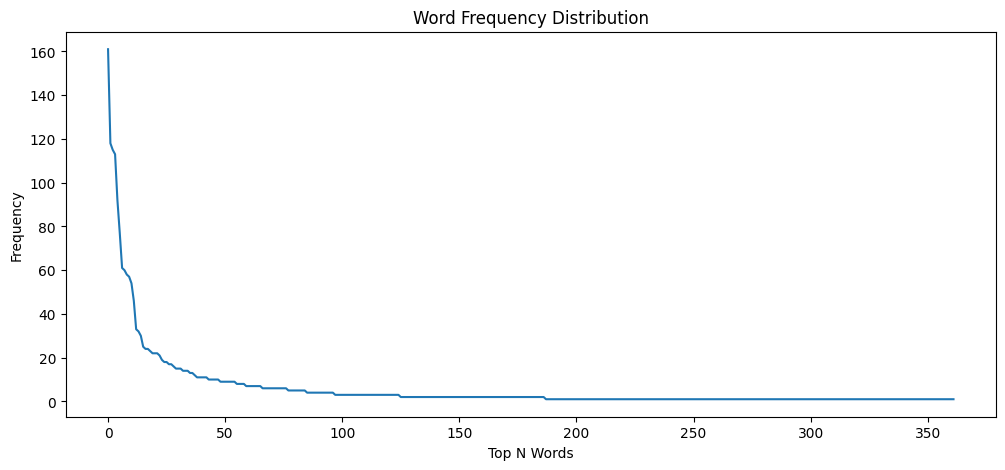

In [2]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('/content/malnutrition_cases.csv')
# Sample text corpus (replace with your dataset)
documents = df['Note_Column'].astype(str).tolist()

# Tokenize and count word frequency
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)
word_counts = X.toarray().sum(axis=0)

# Get words and frequencies
vocab = vectorizer.get_feature_names_out()
word_freq = dict(zip(vocab, word_counts))

# Sort words by frequency
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Plot the top 1000 words
plt.figure(figsize=(12, 5))
plt.plot([x[1] for x in sorted_word_freq])
plt.xlabel("Top N Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution")
plt.show()
